## Visualize Reexplore Training Results
Takes in a job directory and output bbox and segm AP curves for all settings 
(class, instance, gtfixed, pfixed)

2 training samples
10 training samples
Test AP on max Val AP
visualize /checkpoint/apratik/jobs/reexplore/training/18-05-2022/12:42:56/
train_dirs 60
results for 1 trajectories ...
0_s1ppr2_5_0 [[AP(bbox=49.62046204620462, segm=61.778167353958736)], [AP(bbox=50.48901252354339, segm=60.9934582823319)], [AP(bbox=46.257479044607756, segm=54.67613263157818)]]
0_s1ppr2_5_4 [[AP(bbox=54.67114568599717, segm=61.44875389794618)], [AP(bbox=56.45285242809995, segm=64.06078801157426)], [AP(bbox=49.01854471161401, segm=57.30573628791451)]]
0_s1ppr2_5_8 [[AP(bbox=59.55926449787836, segm=64.0179959554397)], [AP(bbox=58.043054305430545, segm=67.88998964412572)], [AP(bbox=53.69812365851969, segm=66.27956762493746)]]
0_s1ppr2_5_12 [[AP(bbox=58.54957638621004, segm=68.68917606046318)], [AP(bbox=59.48858206283948, segm=68.11941908476562)], [AP(bbox=51.11896903976111, segm=60.84409869558384)]]
0_s1ppr2_5_16 [[AP(bbox=56.5100683000631, segm=63.23524449709408)], [AP(bbox=55.03333071402379, segm=66.656058462

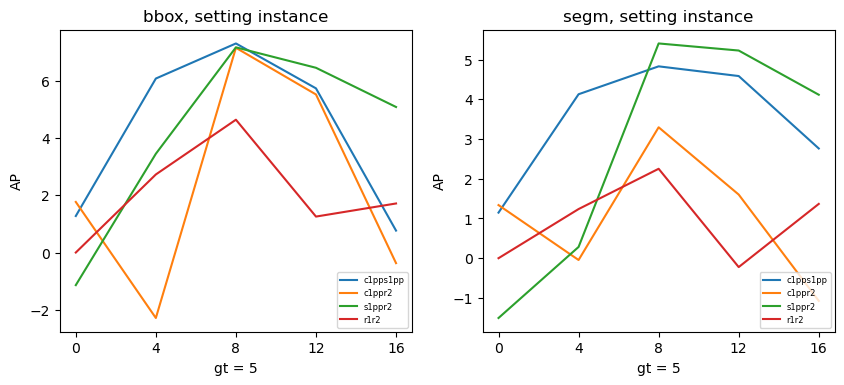

In [229]:
import glob
import json
import os
from typing import Union
from collections import namedtuple, defaultdict
import numpy as np
import matplotlib.pyplot as plt 
from math import sqrt


AP = namedtuple('AP', 'bbox, segm')
# heuristics = ['e1r1r2', 'e1s1r2', 'e1c1lr2']

def load_json(json_path):
    lines = []
    # print(f'looking at {json_path}')
    with open(json_path, 'r') as f:
        ls = f.readlines()
        for line in ls:
            try:
                lines.append(json.loads(line))
            except json.JSONDecodeError:
                print(f'JSONDecodeError {len(line), line[:2]}')
                continue
    return lines

def get_traj_heuristic_gt_p(j):
    j = j.split('/')
    traj = '0' #j[j.index(setting)-1]
    gt = '5'
    heu = j[-4]
    pred_label = j[-2]
    p = pred_label[pred_label.find('pred_label_p') + len('pred_label_p'):-1]
    return traj, heu, gt, p

def get_best_ap(train_dir, setting):
    """
    has metrics for each hyperparam set. 
    find lowest validation loss, and take corresponding training AP.
    """
    def get_ap(l, split):
        ap_bbox, ap_segm = None, None
        prefix = split # '_val' if setting == 'instance' else '_test'
        for k, v in l.items():
            if k.endswith(f'{prefix}/bbox/AP'):
                # print(k)
                ap_bbox = l[k]
            if k.endswith(f'{prefix}/segm/AP'):
                # print(k)
                ap_segm = l[k]
        # print(f'get_ap {ap_bbox, ap_segm}')
        return AP(ap_bbox, ap_segm)            

    def process_json(j):
        x = load_json(m)
        best_val, best_ap, best_val_ap = float('inf'), AP(0, 0), AP(0,0)
        best_iter = 0
        for l in x:
            if 'validation_loss' in l:
                val_loss = l['validation_loss']
                ap = get_ap(l, '_val')
                # print(f'ap {ap}')
                if ap.segm is not None and ap.segm  > best_val_ap.segm:
                    best_ap = get_ap(l, '_test')
                    best_val = val_loss
                    best_val_ap = ap
                    best_iter = l['iteration']
        
#         for l in x:
#             if 'validation_loss' in l:
#                 val_loss = l['validation_loss']
#                 if val_loss < best_val:
#                     best_val = val_loss
#                     best_iter = l['iteration']
#                     ap = get_ap(l, '_test')
#                     if ap.bbox is not None and ap.segm is not None:
#                         best_ap = ap
        
        return best_val, best_ap, best_iter
    
    metric_jsons = glob.glob(train_dir + '/**/metrics.json', recursive=True)        

    # Group json by hyperparms
    def group_by(jsons):
        mj = defaultdict(list)
        for j in jsons:
            js = j.split('/')
            
            def extract_heu_idx(js):
                for h in heuristics:
                    if h in js:
                        return js.index(h)
                return -1
            
            tix = extract_heu_idx(js)
            key = '_'.join(js[tix: tix+6])
            mj[key].append(j)
        return mj

    metric_jsons = group_by(metric_jsons)
    # print(f'printing {len(metric_jsons)} metric_json')
    # for m, v in metric_jsons.items():
    #     print(f'\nkey {m}')
    #     for vv in v:
    #           print(f'value {vv}')

    best_val, best_test_ap = float('inf'), AP(0,0)
    best_mjson = None

    for k, v in metric_jsons.items():
        # process all jsons for this hyperparam set
        val_losses, test_aps = [], []
        for m in v:
            val_loss, test_ap, best_iter = process_json(m)
            # print(f'metric_json {m}, val_loss {val_loss}, test_ap {test_ap}, best_iter {best_iter}')
            # print(f"metric_json {m.split('/')[-8:-6]} test_ap {test_ap}, best_iter {best_iter}")
            val_losses.append(val_loss)
            test_aps.append(test_ap)
        val_avg = np.average(val_losses)
        test_avg = AP(np.average([p.bbox for p in test_aps]), np.average([p.segm for p in test_aps]))
        # print(f'\ntrain_dir {train_dir}\nhyperparams {k}, val_losses {val_losses}, test_aps {test_aps}')
        # print(f'val_avg {val_avg}, test_avg {test_avg}, test {np.min(val_losses)}')
        
        # if val_avg < best_val:
        #     best_val = val_avg
        #     # best_test_ap = test_avg
        #     best_test_ap = test_aps
        #     best_mjson = k

    # for m in metric_jsons:
    #     val_ap, test_ap, it = process_json(m)
    #     if val_ap < best_val:
    #         best_test_ap = test_ap 
    #         best_val = val_ap
    #         best_mjson = m
    #     # print(f'metric_json {m}, val_ap {val_ap}, test_ap {test_ap}')

    # print(f'train_dir {train_dir}\nbest val {best_val}, best iter {best_iter} best_ap {best_test_ap}\nbest mjson {best_mjson}\n')
    # print(best_val, best_test_ap)
    # print(f'train_dir {train_dir}, test_aps {test_aps}')
    return test_aps

def process(j: str) -> Union[str, int, int, float]:
    # print(j)
    traj, heu, gt, p = get_traj_heuristic_gt_p(j)
    # print(heu, gt, p)

    #get best AP- this is not per json, but per pre_label_p0
    try:
        ap = get_best_ap(j, setting)
        return traj, heu, gt, p, ap
        
    except Exception as ex:
        print(f'caught in process: {ex}')
    return None, None, None, None, None

def pprint(d):
    for k, v in d.items():
        for h in heuristics:
            if h in k:
                print(k, v)

def get_values(all_scores, h, gt, p):
        key = '_'.join([h, str(gt), str(p)])
        if key in all_scores:
            aps = all_scores[key]
            # print(f'get_values {key}, {aps}')
            # aps = [x for y in aps for x in y]
            try:
                avg = AP(np.average([p.bbox for p in aps]), np.average([p.segm for p in aps]))
                var = AP(np.var([p.bbox for p in aps]), np.var([p.segm for p in aps]))
            except Exception as ex:
                print(f'exception {ex} key {key} aps {aps}')
                return None, None
            # print(aps, avg, var)
            return avg, var
        
        return None, None

def plot(scores, setting, gts, ps, figname):
    def draw(heu, xs, ys_bbox, ys_bb_err, ys_segm, ys_se_err, ax1, ax2, xlabel):
        # print(f'len xs {len(xs)}, len ys {len(ys_bbox), len(ys_segm)}')
        # print(f'ys_bb_err {ys_bb_err}, ys_se_err {ys_se_err}')
        ax1.set_title(f'bbox, setting {setting}')
        ax1.set_xlabel(xlabel)
        ax1.set_ylabel('AP')
        ax1.plot(xs, ys_bbox, label=heu)
        ax1.fill_between(
            xs, 
            np.asarray(ys_bbox) - np.asarray(ys_bb_err)/2, 
            np.asarray(ys_bbox) + np.asarray(ys_bb_err)/2,
            alpha=0.2
        )
        ax1.set_xticks(xs)
        # ax1.set_ylim( [ -10,10 ] )   
        # ax1.errorbar(xs, ys_bbox, yerr=None, label=heu)
        ax1.legend(loc="lower right", prop={'size':6})
        # ax1.set_ylim(ymin=0)

        ax2.set_title(f'segm, setting {setting}')
        ax2.set_xlabel(xlabel)
        ax2.set_ylabel('AP')
        ax2.plot(xs, ys_segm, label=heu)
        ax2.fill_between(
            xs, 
            np.asarray(ys_segm) - np.asarray(ys_se_err)/2, 
            np.asarray(ys_segm) + np.asarray(ys_se_err)/2,
            alpha=0.2
        )
        ax2.set_xticks(xs)
        # ax2.set_ylim( [ -10,10 ] )   
        # ax2.errorbar(xs, ys_segm, yerr=None, label=heu)
        # ax2.set_ylim(ymin=0)

        ax2.legend(loc="lower right", prop={'size':6})
    
    # for each heuristic, plot gt, p
    
    if len(gts) == 1:
        # ps are the x-values
        # ap are the y-values 
        # xs = ps
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)
        for h in heuristics:
            xs, ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], [], []
            for p in ps:
                y_ap, y_err = get_values(scores, h, gts[0], p)
                if y_ap is not None:
                    xs.append(p)
                    ys_bb.append(y_ap.bbox)
                    ys_bb_err.append(sqrt(y_err.bbox))
                    ys_se.append(y_ap.segm)
                    ys_se_err.append(sqrt(y_err.segm))

            if len(ys_bb) > 0 and len(ys_se) > 0:
                draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, f'gt = {gts[0]}')
        plt.savefig(f'paper_figures/{figname}.jpg')
        plt.show()

    if len(ps) == 1:
        # gts are the x-values
        # ap are the y-values 
        xs = gts
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4), dpi=100)
        for h in heuristics:
            ys_bb, ys_bb_err, ys_se, ys_se_err = [], [], [], []
            for gt in gts:
                y_ap, y_err = get_values(scores, h, gt, ps[0])
                if y_ap is not None:
                    ys_bb.append(y_ap.bbox)
                    ys_bb_err.append(sqrt(y_err.bbox))
                    ys_se.append(y_ap.segm)
                    ys_se_err.append(sqrt(y_err.segm))

            if len(ys_bb) > 0 and len(ys_se) > 0:
                draw(h, xs, ys_bb, ys_bb_err, ys_se, ys_se_err, ax1, ax2, 'p fixed')
        plt.savefig(f'paper_figures/{figname}.jpg')
        plt.show()

def is_eligible(t, with_gt):
    if with_gt:
        return '_with_gt' in t
    return '_with_gt' not in t

def normalize(scores, trajs):
    def sub_ap(a, b):
        if not isinstance(a, AP) or not isinstance(b, AP):
            return AP(0,0)
        return AP(a.bbox-b.bbox, a.segm-b.segm)
    
    # normalize everything with baseline p0
    # get gt, p values for each heuristic
    # normalize with baseline_gt_0
    normalized_scores = defaultdict(list)
    
    # print(f'normalize {scores}')

    for tr in trajs:
        gt = 5
        baseline = scores[f'{tr}_r1r2_{gt}_0']
        print(f'baseline {baseline}')
        for k, v in scores.items():
            if k.startswith(f'{tr}_'):
                print(f'normalizing {k}, v {v}')
                try:
                    if len(v)>0 and len(baseline)>0:
                        normalized_scores[k] = [sub_ap(v[i], baseline[i]) for i in range(len(v))]
                except Exception as ex:
                    pass
                    print(f'exception {ex}, k {k}, v {v}, baseline {baseline}')
                print(f'after {normalized_scores[k]}')
            # print(scores, normalized_scores)
    return normalized_scores

def cumulate(scores):
    cumulative = defaultdict(list)
    for k, v in scores.items():
        new_key = '_'.join(k.split('_')[1:])
        # print(f'new_key {new_key}, values {v}')
        cumulative[new_key].append(v)
    
    # flatten
    for k, v in cumulative.items():
        cumulative[k] = [x for y in v for x in y]
        # print(f'key {k}, values {len(cumulative[k])}')
    return cumulative

def visualize(job_dir, setting, figname, with_gt=False, individual=False):
    """
    visualize setting - gt fixed, p fixed
    draws as many lines as there are heuristic combinations 
    """
    print(f'visualize {job_dir}')
    # train_dirs = glob.glob(job_dir + '/**/training', recursive=True)
    
    # tdirs = [x for x in train_dirs if setting in x]
    # print(f'{len(tdirs), tdirs[:10]} training directories')
    
    all_scores = defaultdict(list) 
    trajs = set()
    
    train_dirs = glob.glob(job_dir + '/**/training', recursive=True)
    print(f'train_dirs {len(train_dirs)}')

    for t in train_dirs:
        # print(f'checking {t}')
        traj, heu, gt, p, ap = process(t)
        # print(f'heu, gt, p, ap, t {heu, gt, p, ap, t}')
        if traj is not None:
            trajs.add(traj)
            all_scores['_'.join([traj, heu, gt, p])].append(ap) 

   
    print(f'results for {len(trajs)} trajectories ...')
   
    # print(all_scores)
    pprint(all_scores)
    for k, v in all_scores.items():
        # print(f'previous {k, v}')
        fv = [x for y in v for x in y]
        all_scores[k] = [AP(np.average([p.bbox for p in fv]), np.average([p.segm for p in fv]))]
        # print(f'after {k, all_scores[k]}')
    # scores = cumulate(all_scores)

    scores = cumulate(normalize(all_scores, trajs))
    print(f'normalized accumulated scores {scores}')
    
    plot(scores, setting, gts=[5], ps=range(0,20,2), figname=figname)
    # plot(gts=[10], ps=range(0,20,2))
    # plot(gts=[10], ps=[0,2,4,6,8])
    # plot(gts=[5,10,15], ps=[2])



# train_dir = '/checkpoint/apratik/jobs/reexplore/training/22-04-2022/20:55:05' # 4/22 run with 17 trajectories
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/26-04-2022/10:36:46' # 4/26 run with 12 trajectories

# large >200 run, 4 training samples each, interrupted after ~12 hours 
# train_dir ='/checkpoint/apratik/jobs/reexplore/training/01-05-2022/02:31:48' 

# large >200 run, 1 training sample each, interrupted due to random seed bug
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/01-05-2022/21:19:26' 

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/05-05-2022/15:20:53' # final run

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/12:42:43' # test run for 82, s1 and r1, no early stopping, 600 iters
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/12:41:26/' # local test run for 82, s1, no early stopping, 600 iters, too slow

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/06-05-2022/14:19:46' # 3 runs each

# first run with s1pp and c1pp
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/07-05-2022/12:47:24'

# run with fixes here https://docs.google.com/presentation/d/1aNDu5mabOPebcgoowaBtnfQAbdRTInsl337TZeDwKqY/edit#slide=id.g11bb13202eb_0_59
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/00:56:20' 

# run with fixes, just more trajectoris (33), no noise
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/08:01:32/'
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/08-05-2022/20:06:11/'

# run with fixes, small batch, noise
# train_dir = '/checkpoint/soumith/jobs/reexplore/training/11-05-2022/09:51:35/'
# train_dir = '/checkpoint/soumith/jobs/reexplore/training/13-05-2022/08:33:06'

# train_dir = '/checkpoint/apratik/jobs/reexplore/training/16-05-2022/21:00:53/'

# val set phone pictures
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/17-05-2022/15:14:41/'

# test set phone pictures, 3 classes only - plant, armchair, hamper
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/17-05-2022/14:44:43/'

# model frozen at 5, 1 training run only
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/17-05-2022/22:39:24/'

# model frozen at 5, backbone frozen (is that redundant?), 2 training runs - froze too much I think?
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/17-05-2022/23:54:27'

print(f'2 training samples')
# train_dir = '/checkpoint/apratik/jobs/reexplore/training/18-05-2022/01:32:43/'

print(f'10 training samples')
train_dir = '/checkpoint/apratik/jobs/reexplore/training/18-05-2022/12:42:56/'


setting = 'instance'
noise = 'no_noise'
gtorpfix = 'gtfix'

heuristics = [
    # 'r1',
    # 'c1pp',
    # 's1pp',
    'c1pps1pp',
    'c1ppr2',
    's1ppr2',
    'r1r2',
]

print(f'Test AP on max Val AP')
visualize(train_dir, setting, f'[{setting}]_[{noise}]_[{gtorpfix}]', individual=True)
# visualize(train_dir, setting, f'[{setting}]_[{noise}]_[{gtorpfix}]_withGT', with_gt=True)
cnt = 0
# trajs = set()
# for x in os.listdir(train_dir):
#     if x.isdigit():
#         trajs.add(x)
#         visualize(os.path.join(train_dir, x), 'class', individual=True)
        # visualize(os.path.join(train_dir, x), 'instance', with_gt=True, individual=True)
        # break

        # visualize(os.path.join(train_dir, x), 'instance', with_gt=True)

# visualize(train_dir, 'instance', with_gt=True)